In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [2]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [3]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset

def pca_labels(dataset, n_components):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])

    targets_np = targets.numpy()
    pca = PCA(n_components=n_components)
    reduced_labels_np = pca.fit_transform(targets_np)
    reduced_labels = torch.tensor(reduced_labels_np, dtype=torch.float32)
    reduced_labels = nn.functional.normalize(reduced_labels, p=2, dim=1)
    dataset = TensorDataset(features, reduced_labels)

    return dataset

In [4]:
class CustomContrastiveLoss(nn.Module):
    def __init__(self, sigma=1):
        super(CustomContrastiveLoss, self).__init__()
#         self.margin = margin 
        self.sigma = sigma 
    
    def gaussian_kernel(self, x, y):
        # squared Euclidean distance
        squared_dist = torch.sum((x - y) ** 2, dim=1)
        # Apply the Gaussian kernel
        return torch.exp(-squared_dist / (2 * self.sigma ** 2))

    def forward(self, features, targets):
        # Gaussian kernel for the positive pairs
        positive_kernel = self.gaussian_kernel(features, targets)

        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    #Gaussian kernel for distances to features and targets
                    kernel_to_features = self.gaussian_kernel(targets[i].unsqueeze(0), features[j].unsqueeze(0))
                    kernel_to_targets = self.gaussian_kernel(targets[i].unsqueeze(0), targets[j].unsqueeze(0))
                    
                    repulsion_loss += kernel_to_features + kernel_to_targets

        attraction_loss = 1-positive_kernel.mean()
        repulsion_loss = repulsion_loss / (batch_size * (batch_size - 1))  # Normalize by the number of negative pairs
        # Total loss
        total_loss = attraction_loss + repulsion_loss

        return total_loss

In [5]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [6]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [7]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 24
output_dim = 2
num_epochs = 100


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
temperature = 10
base_temperature = 10 # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 5 # too low values return nan loss
n_splits = 5

In [10]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [11]:
results_cv = []
best_mape = np.inf
best_r2 = -np.inf
best_average_loss = np.inf

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    
    print(f"Starting fold {fold}")
    
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    std_train_subset = standardize_dataset(train_subset)
    std_val_subset = standardize_dataset(val_subset)
    
#     std_train_subset = pca_labels(std_train_subset, 2)
#     std_val_subset = pca_labels(std_val_subset, 2)

    # Now, 'standardized_train_subset' and 'standardized_val_subset' are ready to be used for training and validation
    # Example: Convert them to DataLoader if needed
    train_loader = DataLoader(std_train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(std_val_subset, batch_size=batch_size, shuffle=False)
    
    # Initialize your model, criterion, and optimizer here
    model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
#     model = MLP(input_dim_feat, hidden_dim_feat, output_dim).to(device)

    criterion = CustomContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Fold {fold} | Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
            
    val_losses = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for features, targets in val_loader:
            features = features.to(device).float()
            targets = targets.to(device)

            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            val_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)
        val_losses =np.array(val_losses)
        average_loss = total_loss / total_samples
        if best_average_loss > average_loss:
            best_average_loss = average_loss
            save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
    r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
#     if mape_train < best_mae and r2_train > best_r2: # saving the one which has the best train metrics
#         best_mape = mape_train
#         best_r2 = r2_train
#         save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    results_cv.append([fold, mape_train, r2_train, mape_val, r2_val])

    

Starting fold 0
Fold 0 | Epoch 0 | Mean Loss 1.6180138776176853
Fold 0 | Epoch 1 | Mean Loss 1.4637084760163959
Fold 0 | Epoch 2 | Mean Loss 1.4252541943600303
Fold 0 | Epoch 3 | Mean Loss 1.3318905140224255
Fold 0 | Epoch 4 | Mean Loss 1.325314013581527
Fold 0 | Epoch 5 | Mean Loss 1.36755885575947
Fold 0 | Epoch 6 | Mean Loss 1.3220567326796682
Fold 0 | Epoch 7 | Mean Loss 1.281620276601691
Fold 0 | Epoch 8 | Mean Loss 1.2406306015817743
Fold 0 | Epoch 9 | Mean Loss 1.243657306620949
Fold 0 | Epoch 10 | Mean Loss 1.2172437435702275
Fold 0 | Epoch 11 | Mean Loss 1.223680897762901
Fold 0 | Epoch 12 | Mean Loss 1.2080912621397721
Fold 0 | Epoch 13 | Mean Loss 1.2001502702110691
Fold 0 | Epoch 14 | Mean Loss 1.0945451416467364
Fold 0 | Epoch 15 | Mean Loss 1.1394825483623303
Fold 0 | Epoch 16 | Mean Loss 1.0624191917871173
Fold 0 | Epoch 17 | Mean Loss 1.0390910286652415
Fold 0 | Epoch 18 | Mean Loss 1.1105167332448458
Fold 0 | Epoch 19 | Mean Loss 1.0465066087873358
Fold 0 | Epoch 20 | 

Fold 1 | Epoch 67 | Mean Loss 0.8628687168422499
Fold 1 | Epoch 68 | Mean Loss 0.8450127369479129
Fold 1 | Epoch 69 | Mean Loss 0.9221108555793762
Fold 1 | Epoch 70 | Mean Loss 0.8966137892321536
Fold 1 | Epoch 71 | Mean Loss 0.8449661574865642
Fold 1 | Epoch 72 | Mean Loss 0.8783880534924959
Fold 1 | Epoch 73 | Mean Loss 0.8717294021656639
Fold 1 | Epoch 74 | Mean Loss 0.8488222799803081
Fold 1 | Epoch 75 | Mean Loss 0.8416019176181994
Fold 1 | Epoch 76 | Mean Loss 0.9008237625423231
Fold 1 | Epoch 77 | Mean Loss 0.8274706445242229
Fold 1 | Epoch 78 | Mean Loss 0.8533457862703424
Fold 1 | Epoch 79 | Mean Loss 0.8795938334966961
Fold 1 | Epoch 80 | Mean Loss 0.8446668700168007
Fold 1 | Epoch 81 | Mean Loss 0.8643267342918798
Fold 1 | Epoch 82 | Mean Loss 0.8694813502462286
Fold 1 | Epoch 83 | Mean Loss 0.8801786805454054
Fold 1 | Epoch 84 | Mean Loss 0.8722548516173112
Fold 1 | Epoch 85 | Mean Loss 0.8359439686725014
Fold 1 | Epoch 86 | Mean Loss 0.8225617879315427
Fold 1 | Epoch 87 | 

Fold 3 | Epoch 33 | Mean Loss 0.9498321257139507
Fold 3 | Epoch 34 | Mean Loss 0.9407931440754941
Fold 3 | Epoch 35 | Mean Loss 0.9139831599436308
Fold 3 | Epoch 36 | Mean Loss 0.9496508648521022
Fold 3 | Epoch 37 | Mean Loss 0.9721582751525076
Fold 3 | Epoch 38 | Mean Loss 0.9749092114599127
Fold 3 | Epoch 39 | Mean Loss 0.9128520865189401
Fold 3 | Epoch 40 | Mean Loss 0.9571703327329535
Fold 3 | Epoch 41 | Mean Loss 0.8947740730486418
Fold 3 | Epoch 42 | Mean Loss 0.910505053244139
Fold 3 | Epoch 43 | Mean Loss 0.9019431064003393
Fold 3 | Epoch 44 | Mean Loss 0.9006635044750414
Fold 3 | Epoch 45 | Mean Loss 0.9440604134609825
Fold 3 | Epoch 46 | Mean Loss 0.9456989106379057
Fold 3 | Epoch 47 | Mean Loss 0.8883676058367679
Fold 3 | Epoch 48 | Mean Loss 0.9483788891842491
Fold 3 | Epoch 49 | Mean Loss 0.9502430683688113
Fold 3 | Epoch 50 | Mean Loss 0.9709389805793762
Fold 3 | Epoch 51 | Mean Loss 0.9344073816349632
Fold 3 | Epoch 52 | Mean Loss 0.9744149195520502
Fold 3 | Epoch 53 | M

Training target estimator


In [12]:
results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
results_df.to_csv('cv_results_hopkins.csv', index=False)

In [13]:
results_df

,Fold,Train_MAPE,Train_R2,Val_MAPE,Val_R2
0,0,0.778649,0.851456,1.929518,-0.313522
1,1,0.709147,0.897660,1.762746,-0.709778
2,2,0.418443,0.963861,2.961127,-1.104085
3,3,0.409858,0.931573,5.320520,-1.047362
4,4,0.529320,0.895317,4.332622,-1.183104


In [14]:
# Compute and print evaluation metrics if necessary
mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(results_cv)

Training target estimator


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training target estimator
[[0, 0.77864945, 0.8514559573299769, 1.929518, -0.31352233071961], [1, 0.70914745, 0.8976599674738008, 1.762746, -0.7097775938883061], [2, 0.4184432, 0.9638607661500241, 2.9611266, -1.1040852331747673], [3, 0.4098575, 0.9315730060758065, 5.3205204, -1.0473616003515969], [4, 0.5293205, 0.8953167980363276, 4.3326216, -1.183104138521747], ['Overall', 0.5293203, 0.8949245516003379, 4.3326235, -1.1412534820756908]]


## Testing

In [28]:
std_test_dataset = standardize_dataset(test_dataset)
# std_test_dataset = pca_labels(std_test_dataset, 2)
std_test_loader = DataLoader(std_test_dataset, batch_size=batch_size, shuffle=False)



In [24]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim)
model.load_state_dict(torch.load('best_model_hopkins_cv.pt')["model"])
criterion = CustomContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('best_model_hopkins_cv.pt')["optimizer"])

In [25]:
torch.load('best_model_hopkins_cv.pt')["cv_fold"]

0

In [26]:
model.to(device)

MLP(
  (feat_mlp): Sequential(
    (0): Linear(in_features=499500, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1000, out_features=2, bias=True)
  )
  (target_mlp): Sequential(
    (0): Linear(in_features=59, out_features=24, bias=True)
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)

In [30]:
test_losses = []
model.eval()
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)
        print(targets.shape)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

torch.Size([5, 59])
torch.Size([5, 59])
torch.Size([5, 59])
torch.Size([5, 59])
torch.Size([5, 59])
torch.Size([5, 59])
Mean Test Loss:   1.37


In [31]:
emb_features = np.row_stack(emb_features)

In [32]:
emb_targets = np.row_stack(emb_targets)

In [33]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [34]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [35]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

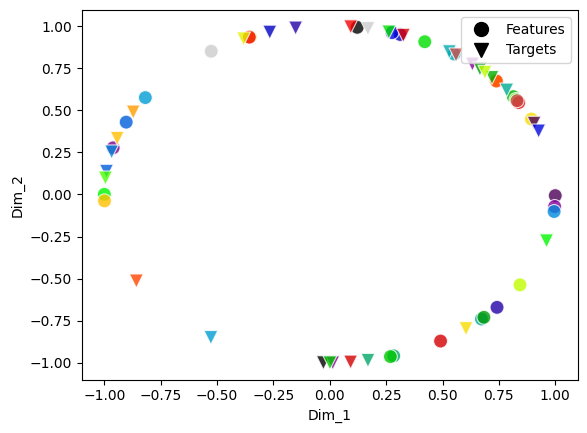

In [36]:
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
# plt.xlim(-1.2, 1.2)
# plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])


In [41]:
embeddings

,Dim_1,Dim_2,sub,Type
0,0.965320,-0.261070,1,Features
1,-0.710620,-0.703576,2,Features
2,-0.954792,-0.297276,3,Features
3,-0.984910,-0.173069,4,Features
4,-0.943903,-0.330222,5,Features
...,...,...,...,...
112,0.922472,-0.386064,113,Targets
113,-0.851817,0.523839,114,Targets
114,0.986375,-0.164511,115,Targets
115,0.998986,0.045019,116,Targets


In [44]:
embeddings[(embeddings['sub'] == 3) & (embeddings['Type'] == "Features")]

,Dim_1,Dim_2,sub,Type
2,-0.954792,-0.297276,3,Features


In [45]:
embeddings[(embeddings['sub'] == 3) & (embeddings['Type'] == "Targets")]

,Dim_1,Dim_2,sub,Type
2,0.997188,0.074936,3,Targets


In [24]:
mae_train, mae_test = compute_target_score(model, train_loader, test_loader, device, 'mape')
r2_train, r2_test = compute_target_score(model, train_loader, test_loader, device, 'r2')

print(f"Train MAPE: {mae_train}, Test MAPE: {mae_test}.")
print(f"Train R2: {r2_train}, Test R2: {r2_test}.")

Training target estimator
Training target estimator
Train MAPE: 1.5097272396087646, Test MAPE: 1.603095293045044.
Train R2: 6.000279517137663e-07, Test R2: -0.048680421194799206.


## Learning curve

In [25]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, train_loader, device)
X_test, y_test = gather_feats_targets(model, test_loader, device)


In [26]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [27]:
estimator = TargetEstimator()

In [28]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


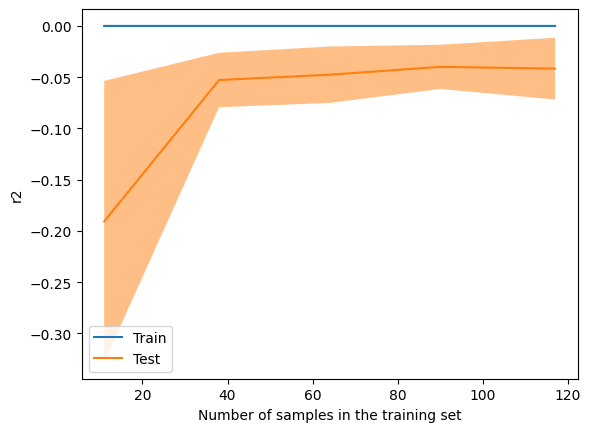

In [29]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
